<a href="https://colab.research.google.com/github/wxmiked/cannabis-deforestation/blob/feature-add-download-naip/notebooks/custom-raster-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAIP Custom Raster Datasets

Mike Dvorak [mike@weathertactics.io](mailto:mike@weathertactics.io)

A custom `GeoDataset` class for the [Microsoft Planetary Computer NAIP archive](https://planetarycomputer.microsoft.com/dataset/naip). This notebook is derived from the Custom Raster Datasets tutorial on the TorchGeo site originally written by Ritwik Gupta.

## Setup

First, we install TorchGeo and a couple of other dependencies for downloading data from Microsoft's Planetary Computer.

In [3]:
%pip install torchgeo planetary_computer pystac

Note: you may need to restart the kernel to use updated packages.


## Imports

Next, we import TorchGeo and any other libraries we need.

In [4]:
import os
import tempfile
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import planetary_computer
import pystac
import torch
from torch.utils.data import DataLoader

from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler
from torchgeo.transforms import AppendNDBI, AppendNDVI, AppendNDWI

%matplotlib inline
plt.rcParams['figure.figsize'] = (4, 4)

## Downloading

Let's download some data to play around with. In this example, we'll create a dataset for loading Sentinel-2 images. Yes, TorchGeo already has a built-in class for this, but we'll use it as an example of the steps you would need to take to add a dataset that isn't yet available in TorchGeo. We'll show how to download a few bands of Sentinel-2 imagery from the Planetary Computer. This may take a few minutes.

In [5]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [6]:
time_range = "2016-01-01/2016-12-31"
bbox = [-120.56802294590112,38.307368125981206,-120.47440785318257,38.36284893862011]


search = catalog.search(collections=["naip"], bbox=bbox, datetime=time_range)
items = search.item_collection()
items

In [7]:
import os
from urllib.parse import urlparse
import tempfile

root = os.path.join(tempfile.gettempdir(), 'naip')
os.makedirs(root, exist_ok=True)  # Ensure the directory exists

for item in items:
    signed_item = planetary_computer.sign(item)
    url = signed_item.assets["image"].href
    filename = urlparse(url).path.split('/')[-1]
    
    # Check if file already exists
    filepath = os.path.join(root, filename)
    if not os.path.exists(filepath):
        print(f"Downloading {filename}...")
        download_url(url, root, filename)
    else:
        print(f"Skipping {filename} - already exists")

Skipping m_3812045_sw_10_h_20160620.tif - already exists
Skipping m_3812045_nw_10_h_20160620.tif - already exists
Skipping m_3812044_sw_10_h_20160620.tif - already exists
Skipping m_3812044_se_10_h_20160620.tif - already exists
Skipping m_3812044_nw_10_h_20160620.tif - already exists
Skipping m_3812044_ne_10_h_20160620.tif - already exists


This downloads the following files:

In [23]:
print(root)
sorted(os.listdir(root))

/var/folders/56/gwh1m3s973l4jc97_wdr2qqw0000gn/T/naip


['m_3812044_ne_10_h_20160620.tif',
 'm_3812044_nw_10_h_20160620.tif',
 'm_3812044_se_10_h_20160620.tif',
 'm_3812044_sw_10_h_20160620.tif',
 'm_3812045_nw_10_h_20160620.tif',
 'm_3812045_sw_10_h_20160620.tif']

## Defining a custom NAIP dataset

Using the filenames above, we can create new NAIP class that is a sub-class of `RasterDataset`. We also add a plotting function.

In [8]:
class Naip(RasterDataset):
    filename_glob = 'm_*.tif'
    filename_regex = r'^m_[0-9]{7}_[nsew]{2}_10_h_(?P<date>\d{8})'
    date_format = '%Y%m%d'
    is_image = True
    separate_files = False
    all_bands = ('R', 'G', 'B', 'NIR')
    rgb_bands = ('R', 'G', 'B',)

    # Normalize image to [0, 1]
    def __getitem__(self, index):
        sample = super().__getitem__(index)
        image = sample['image']
        image = (image - image.min()) / (image.max() - image.min())
        sample['image'] = image
        return sample

    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder the image
        image = sample['image'][rgb_indices].permute(1, 2, 0)

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

In [1]:
naip_dataset = Naip(root)
print(naip_dataset)

NameError: name 'Naip' is not defined

Let's plot an image to see what it looks like. We'll use `RandomGeoSampler` to load small patches from each image.

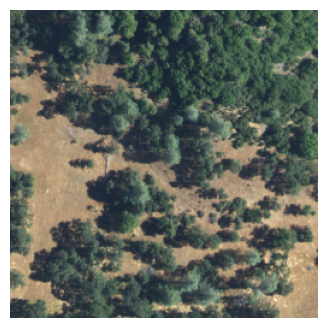

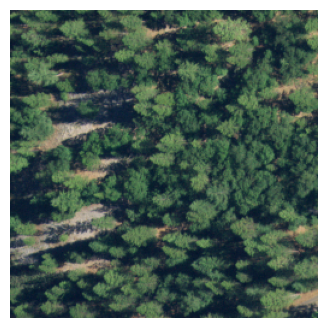

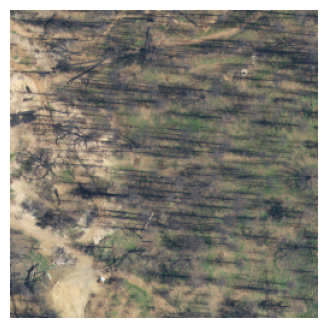

In [10]:
naip_dataset = Naip(root)
g = torch.Generator().manual_seed(1)
sampler = RandomGeoSampler(naip_dataset, size=256, length=3)
dataloader = DataLoader(naip_dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    naip_dataset.plot(sample)
    plt.axis('off')
    plt.show()
    plt.close()

# NDVI

Append Normalized Difference Vegetation Index (NDVI) and Normalized Difference Water Index (NDWI).

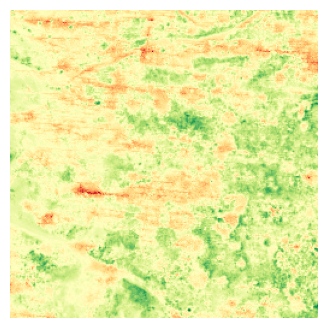

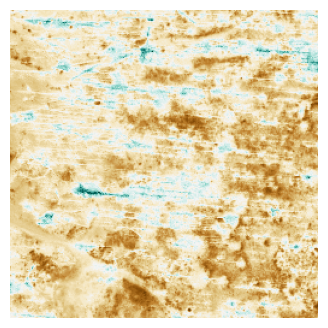

In [11]:
# NDVI is appended to channel dimension (dim=0)
indexNdvi = AppendNDVI(index_nir=naip_dataset.all_bands.index('NIR'), index_red=naip_dataset.all_bands.index('R'))
image = sample['image']
image = indexNdvi(image)[0]

# Normalize from [-1, 1] -> [0, 1] for visualization
image[-1] = (image[-1] + 1) / 2


plt.imshow(image[-1], cmap='RdYlGn')
plt.axis('off')
plt.show()
plt.close()

# NDWI is appended to channel dimension (dim=0)
indexNdwi = AppendNDWI(index_green=naip_dataset.all_bands.index('G'), index_nir=naip_dataset.all_bands.index('NIR'))
image = sample['image']
image = indexNdwi(image)[0]

# Normalize from [-1, 1] -> [0, 1] for visualization
image[-1] = (image[-1] + 1) / 2

plt.imshow(image[-1], cmap='BrBG')
plt.axis('off')
plt.show()
plt.close()